# Introduction

In [3]:
pip install umap-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, spacy, umap
from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from xgboost import XGBClassifier

Mounted at /content/drive


In [5]:
filepath = 'drive/MyDrive/Jacaton/AutomatedAbstraction-DrivenData/Data'
filenames = os.listdir(filepath)
filenames

['submission_format_OfwLSFE.csv',
 'train_labels_JxtENGl.csv',
 'smoke_test_features_bWOfr2M.csv',
 'train_features_X4juyT6.csv',
 'smoke_test_labels_waBGl8d.csv']

In [6]:
datas = []
for idx, filename in enumerate(filenames):
  datas.append(pd.read_csv(os.path.join(filepath, filename), index_col=0))

# Useful functions

In [7]:
def DescribeDf(df):
  print(f"# Rows: {df.shape[0]}")
  print(f"# Columns: {df.shape[1]}")
  print(f"# NaN vals: {df.isna().sum().sum()}")
  display(df.head())

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
def TextPreprocess(text):
  doc = nlp(text)
  preprocessed_text = []
  for token in doc:
    # Remove punctuation
    if token.is_punct or token.is_space:
      continue
    # Lemmatization, plural to singular
    elif token.pos_ == "VERB" or token.tag_ == "NNS" or token.tag_ == "NNPS":
      preprocessed_text.append(token.lemma_)
    else:
      preprocessed_text.append(token.text)
  return ' '.join(preprocessed_text)

def CategoryAnalysis(df):
  num_cols = 4
  num_plots = len(df.columns)
  num_rows = (num_plots + num_cols - 1) // num_cols

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_plots, num_rows * 2))
  axes = axes.flatten()
  for idx, col in enumerate(df.columns):
      counts = df[col].value_counts()
      counts_df = pd.DataFrame(zip(counts.values, counts.index), columns=["count", "category"])
      sns.barplot(x='category', y='count', data=counts_df, palette='viridis', hue='category', dodge=False, ax=axes[idx])
      axes[idx].set_title(col)
      axes[idx].set_xlabel('')
      axes[idx].set_ylabel('')
  for ax in axes[num_plots:]:
      ax.axis('off')

  plt.tight_layout()
  plt.show()

# Exploratory Data Analysis

Submission format

In [8]:
DescribeDf(datas[0])

# Rows: 1000
# Columns: 23
# NaN vals: 0


,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,SubstanceAbuseProblem,MentalHealthProblem,DiagnosisAnxiety,DiagnosisDepressionDysthymia,DiagnosisBipolar,...,Argument,SchoolProblem,RecentCriminalLegalProblem,SuicideNote,SuicideIntentDisclosed,DisclosedToIntimatePartner,DisclosedToOtherFamilyMember,DisclosedToFriend,InjuryLocationType,WeaponType1
uid,,,,,,,,,,,,,,,,,,,,,
aacz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,12
aafi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,12
aagw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,12
aant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,12
aapd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,12


Train features

In [ ]:
features_train = datas[3]
DescribeDf(features_train)

# Rows: 4000
# Columns: 2
# NaN vals: 0


,NarrativeLE,NarrativeCME
uid,,
aaaf,V (XX XX) shot himself in a motor vehicle.The ...,V (XX XX) shot himself in a motor vehicle.The ...
aaby,V was XXXX. V was found in the basement of his...,V was XXXX. V was found in the basement of hi...
aacl,V was XXXX. V was found in his residence unres...,V was XXXX. V was found in his residence suffe...
aacn,"The victim, a XX XX who had recently returned ...",On the day of the fatal event in the early mor...
aadb,XX XX V found deceased at home by his grandpar...,XX XX V found deceased at home by his grandpar...


Train labels

In [ ]:
target_train = datas[1]
DescribeDf(target_train)

# Rows: 4000
# Columns: 23
# NaN vals: 0


,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,SubstanceAbuseProblem,MentalHealthProblem,DiagnosisAnxiety,DiagnosisDepressionDysthymia,DiagnosisBipolar,...,Argument,SchoolProblem,RecentCriminalLegalProblem,SuicideNote,SuicideIntentDisclosed,DisclosedToIntimatePartner,DisclosedToOtherFamilyMember,DisclosedToFriend,InjuryLocationType,WeaponType1
uid,,,,,,,,,,,,,,,,,,,,,
aaaf,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,2,5
aaby,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
aacl,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,1,0,1,0,1,5
aacn,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
aadb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,1,6


 Smoke test features

In [ ]:
features_test = datas[2]
DescribeDf(features_test)

# Rows: 25
# Columns: 2
# NaN vals: 0


,NarrativeLE,NarrativeCME
uid,,
ajrd,V was XXXX. V was found in an oak tree in a wo...,V was XXXX. V was found inside his residence ...
aomw,The V is a XX XX who died as a result of Hangi...,This XX XX V died as a result of Hanging. The...
asgb,"The XX XX victim had an intentional, self-infl...","The victim was a XX XX with an intentional, se..."
aueg,LE summary:V Demographics data is consistent w...,"XX YO, XX, lived w/ a roommate; Employment - M..."
bdji,A XX XX (V) was found unresponsive with a GSW ...,V is a XX XX with a medical history of alcohol...


Smoke test labels

In [ ]:
target_test = datas[4]
DescribeDf(target_test)

# Rows: 25
# Columns: 23
# NaN vals: 0


,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,SubstanceAbuseProblem,MentalHealthProblem,DiagnosisAnxiety,DiagnosisDepressionDysthymia,DiagnosisBipolar,...,Argument,SchoolProblem,RecentCriminalLegalProblem,SuicideNote,SuicideIntentDisclosed,DisclosedToIntimatePartner,DisclosedToOtherFamilyMember,DisclosedToFriend,InjuryLocationType,WeaponType1
uid,,,,,,,,,,,,,,,,,,,,,
ajrd,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,1,5
aomw,1,1,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,6
asgb,0,1,1,1,1,0,1,0,0,0,...,1,1,0,0,1,0,1,0,1,5
aueg,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,5
bdji,1,0,1,1,1,1,1,0,1,0,...,0,0,0,0,1,1,0,0,1,5


## Categories

### Train

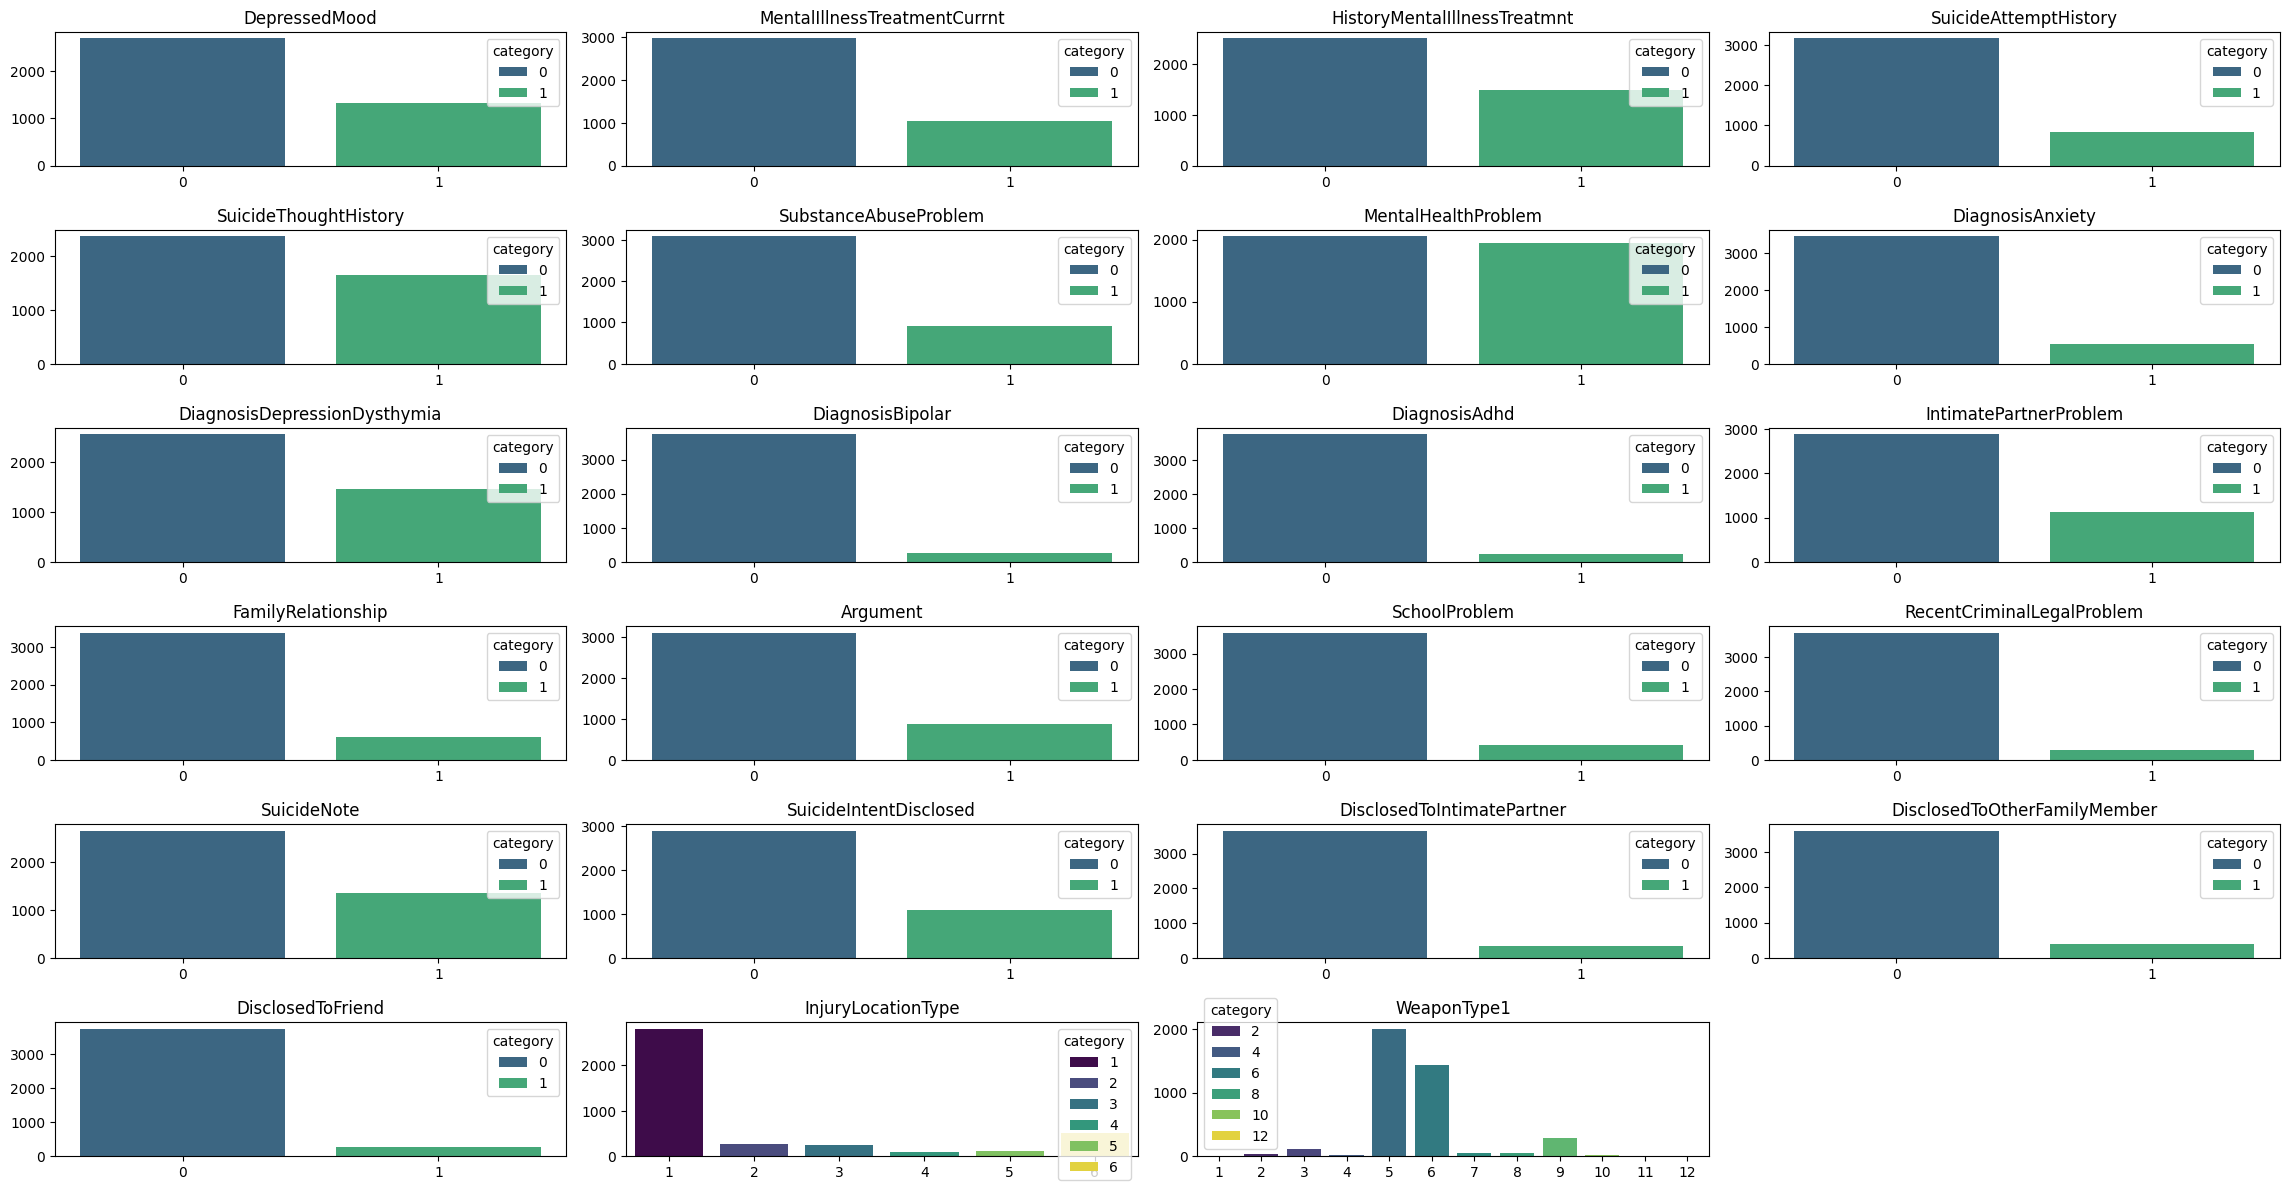

In [ ]:
CategoryAnalysis(target_train)

### Test

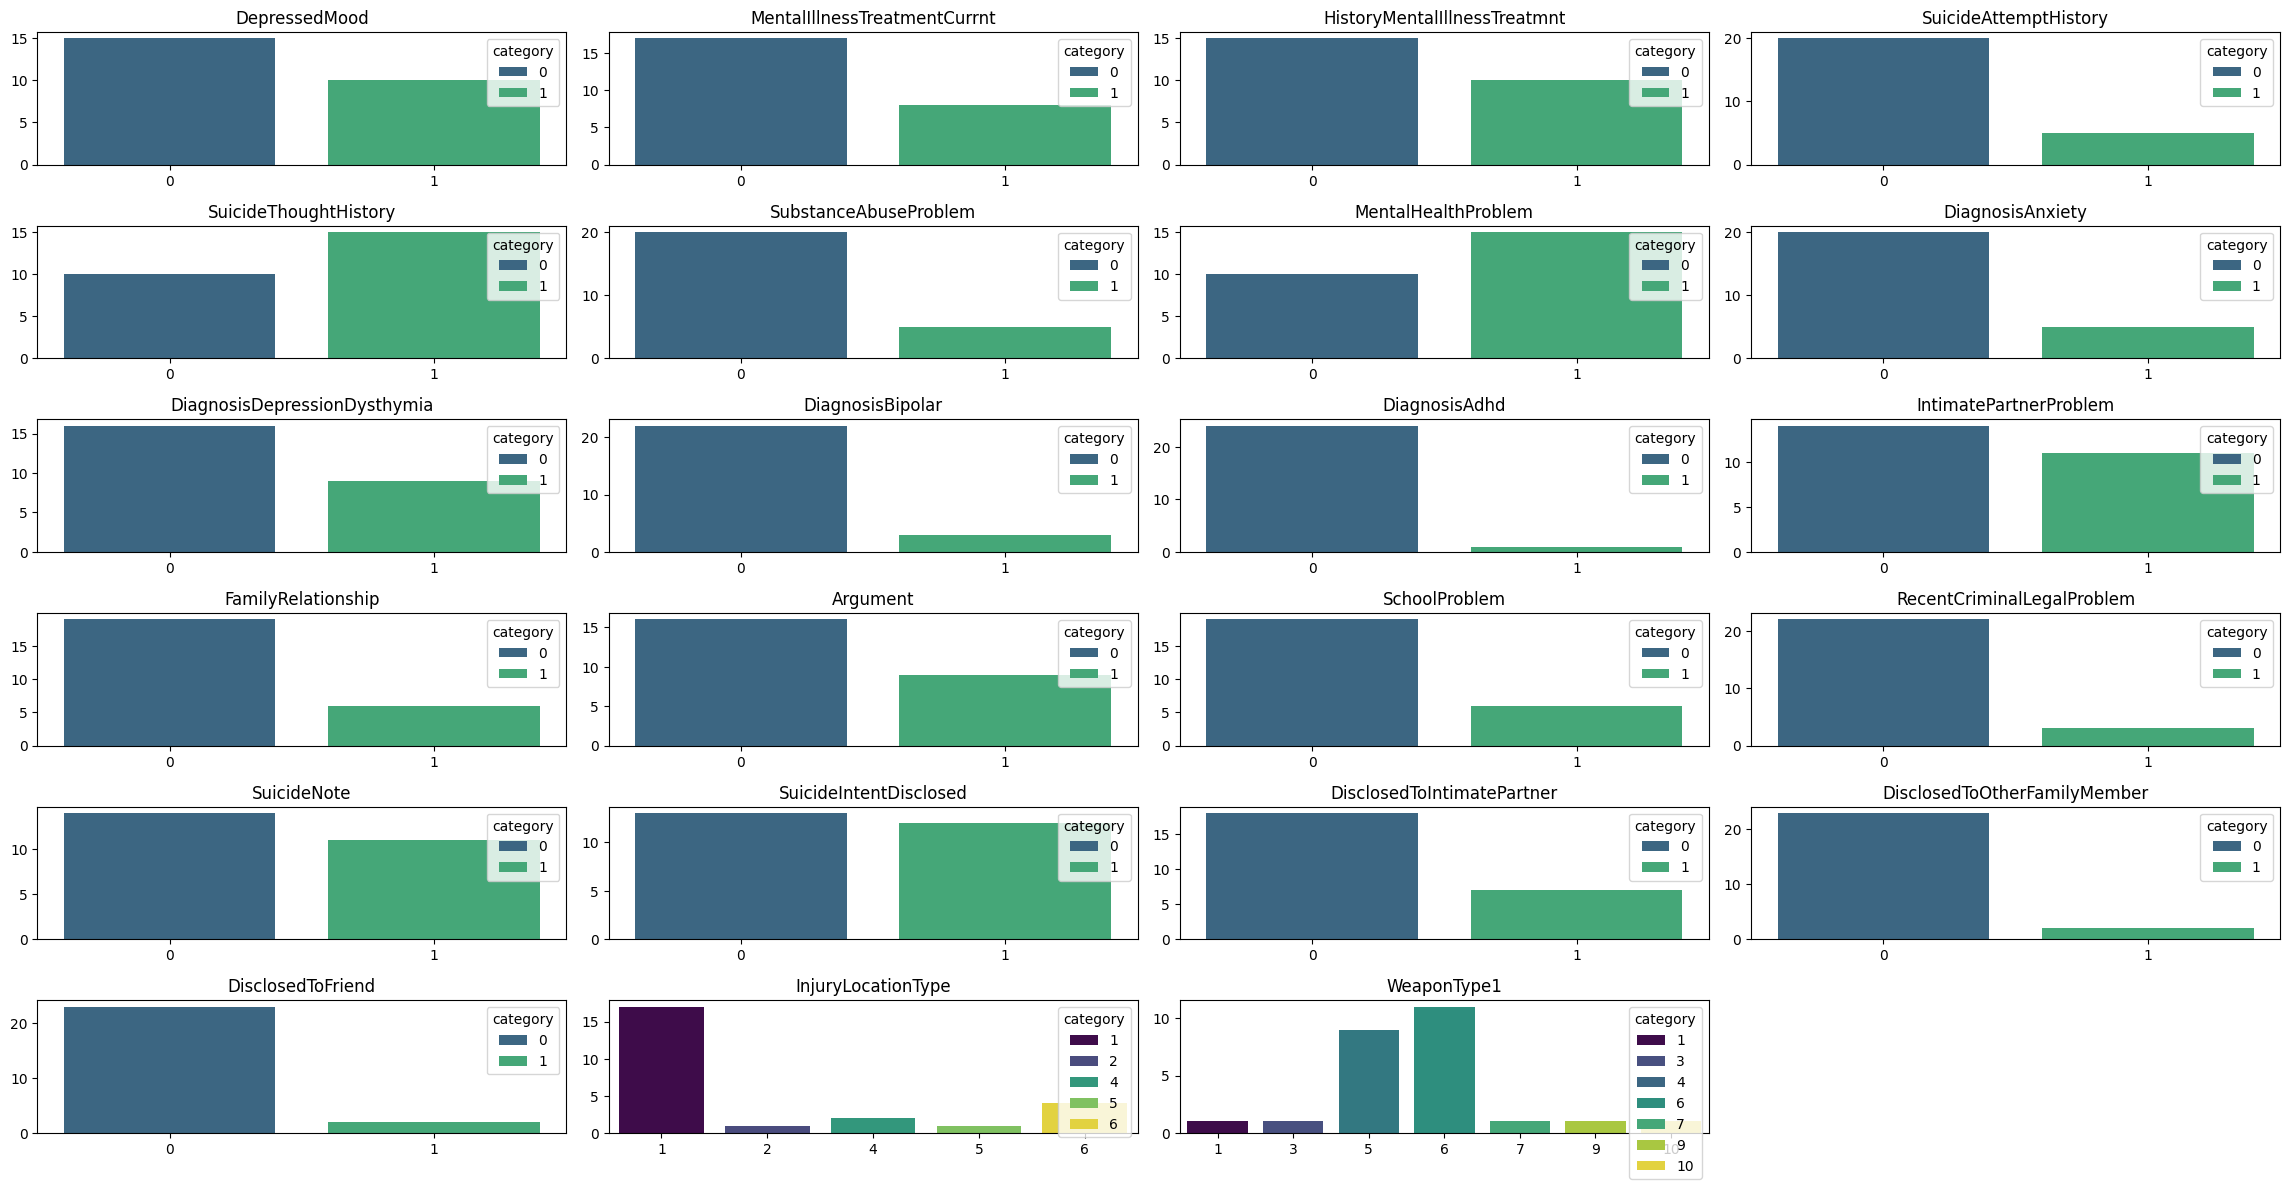

In [ ]:
CategoryAnalysis(target_test)

### Comparation

In [ ]:
for col in target_train.columns:
  print(f"TRAIN {col} :{sorted(target_train[col].unique())}")
  print(f"TEST {col}:{sorted(target_test[col].unique())}")
  print("-"*40)

TRAIN DepressedMood :[0, 1]
TEST DepressedMood:[0, 1]
----------------------------------------
TRAIN MentalIllnessTreatmentCurrnt :[0, 1]
TEST MentalIllnessTreatmentCurrnt:[0, 1]
----------------------------------------
TRAIN HistoryMentalIllnessTreatmnt :[0, 1]
TEST HistoryMentalIllnessTreatmnt:[0, 1]
----------------------------------------
TRAIN SuicideAttemptHistory :[0, 1]
TEST SuicideAttemptHistory:[0, 1]
----------------------------------------
TRAIN SuicideThoughtHistory :[0, 1]
TEST SuicideThoughtHistory:[0, 1]
----------------------------------------
TRAIN SubstanceAbuseProblem :[0, 1]
TEST SubstanceAbuseProblem:[0, 1]
----------------------------------------
TRAIN MentalHealthProblem :[0, 1]
TEST MentalHealthProblem:[0, 1]
----------------------------------------
TRAIN DiagnosisAnxiety :[0, 1]
TEST DiagnosisAnxiety:[0, 1]
----------------------------------------
TRAIN DiagnosisDepressionDysthymia :[0, 1]
TEST DiagnosisDepressionDysthymia:[0, 1]
------------------------------

## Relabel

In [ ]:
encoders = {}
for col in target_train.columns:
    categories = list(set(target_train[col])) + list(set(target_test[col]))
    encoders[col] = LabelEncoder().fit(np.array(categories))

for col in target_train.columns:
    target_train[col] = encoders[col].transform(target_train[col])
    target_test[col] = encoders[col].transform(target_test[col])

# Feature Engineering

In [ ]:
features_train.head()

,NarrativeLE,NarrativeCME
uid,,
aaaf,V (XX XX) shot himself in a motor vehicle.The ...,V (XX XX) shot himself in a motor vehicle.The ...
aaby,V was XXXX. V was found in the basement of his...,V was XXXX. V was found in the basement of hi...
aacl,V was XXXX. V was found in his residence unres...,V was XXXX. V was found in his residence suffe...
aacn,"The victim, a XX XX who had recently returned ...",On the day of the fatal event in the early mor...
aadb,XX XX V found deceased at home by his grandpar...,XX XX V found deceased at home by his grandpar...


## Text preprocessing

Lower case

In [ ]:
features_train['NarrativeLE'] = features_train['NarrativeLE'].str.lower().str.replace(".", " ")
features_train['NarrativeCME'] = features_train['NarrativeCME'].str.lower().str.replace(".", " ")


features_train.head()

,NarrativeLE,NarrativeCME
uid,,
aaaf,v (xx xx) shot himself in a motor vehicle the ...,v (xx xx) shot himself in a motor vehicle the ...
aaby,v was xxxx v was found in the basement of his...,v was xxxx v was found in the basement of hi...
aacl,v was xxxx v was found in his residence unres...,v was xxxx v was found in his residence suffe...
aacn,"the victim, a xx xx who had recently returned ...",on the day of the fatal event in the early mor...
aadb,xx xx v found deceased at home by his grandpar...,xx xx v found deceased at home by his grandpar...


* Plural to singular
* Lemmatization
* Remove stop words
* Remove punctuation

In [ ]:
features_train['NarrativeLE'] = features_train['NarrativeLE'].apply(TextPreprocess)
features_train['NarrativeCME'] = features_train['NarrativeCME'].apply(TextPreprocess)

features_train.head()

,NarrativeLE,NarrativeCME
uid,,
aaaf,v xx xx shoot himself in a motor vehicle the v...,v xx xx shoot himself in a motor vehicle the v...
aaby,v was xxxx v was find in the basement of his r...,v was xxxx v was find in the basement of his r...
aacl,v was xxxx v was find in his residence unrespo...,v was xxxx v was find in his residence suffer ...
aacn,the victim a xx xx who had recently return to ...,on the day of the fatal event in the early mor...
aadb,xx xx v find decease at home by his grandparen...,xx xx v find decease at home by his grandparen...


In [ ]:
features_train = pd.DataFrame(features_train['NarrativeLE'] + " " + features_train['NarrativeCME'], columns=['Narrative'])

features_train.head()

,Narrative
uid,
aaaf,v xx xx shoot himself in a motor vehicle the v...
aaby,v was xxxx v was find in the basement of his r...
aacl,v was xxxx v was find in his residence unrespo...
aacn,the victim a xx xx who had recently return to ...
aadb,xx xx v find decease at home by his grandparen...


Pipeline for testing preprocessing

In [ ]:
features_test['NarrativeLE'] = features_test['NarrativeLE'].str.lower().str.replace(".", " ").apply(TextPreprocess)
features_test['NarrativeCME'] = features_test['NarrativeCME'].str.lower().str.replace(".", " ").apply(TextPreprocess)
features_test = pd.DataFrame(features_test['NarrativeLE'] + " " + features_test['NarrativeCME'], columns=['Narrative'])

## Vectorization

In [ ]:
# remove_words = ["is", "in", "as", "by", "for", "at", "the", "they", "are", "to", "can"]
# for word in remove_words:
#   features_train["Narrative"] = features_train["Narrative"].str.replace(" " + word + " ", " ")

vectorizer = TfidfVectorizer(ngram_range=(1, 1)).fit(pd.concat([features_train, features_test])["Narrative"])
X_train = vectorizer.transform(features_train["Narrative"])
words = vectorizer.get_feature_names_out()
X_train_df = pd.DataFrame(X_train.toarray(), columns=words)

X_train_df.head()

,00,000,0000,0000hrs,0001,0002,0003,0004,0005,0006,...,zone,zoo,zoom,zs,zyprexa,zyrtec,zzz,â¼,â½,â¾
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
(X_train_df == 0).sum().sort_values()

,0
was,8
the,16
and,35
to,52
of,99
...,...
frusterate,3999
frontier,3999
frim,3999
gp,3999


## Visualization

### PCA

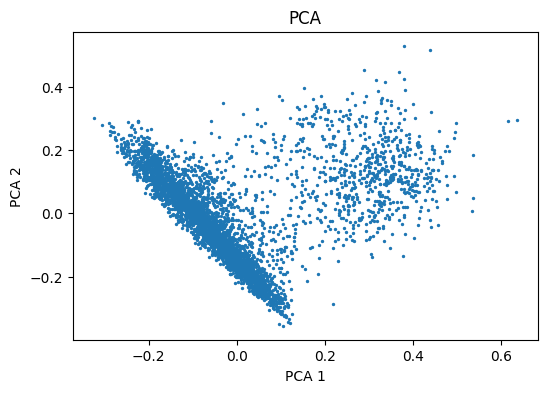

In [ ]:
X_pca = PCA(n_components=2).fit_transform(X_train_df)
features_train['pca1'] = X_pca[:, 0]
features_train['pca2'] = X_pca[:, 1]

plt.figure(figsize=(6, 4))
plt.scatter(features_train['pca1'], features_train['pca2'], s=2)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA")
plt.show()

### UMAP

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


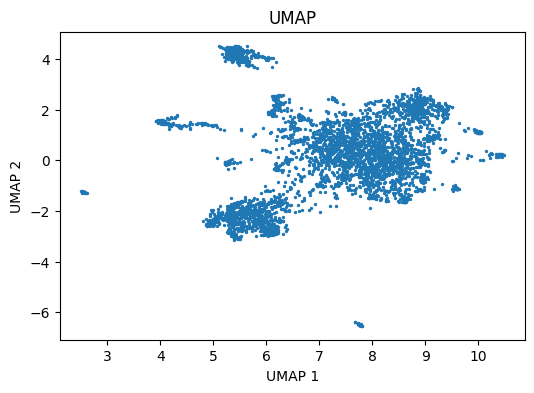

In [ ]:
n_neighbors = 100
min_dist = 0
reducer_2d = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=0)
embedding_2d = reducer_2d.fit_transform(X_train_df)
features_train['umap1'] = embedding_2d[:, 0]
features_train['umap2'] = embedding_2d[:, 1]

plt.figure(figsize=(6, 4))
plt.scatter(features_train['umap1'], features_train['umap2'], s=2)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP")
plt.show()

# Training

In [ ]:
Y_train_df = target_train
Y_train = Y_train_df.values

Verify output correlation

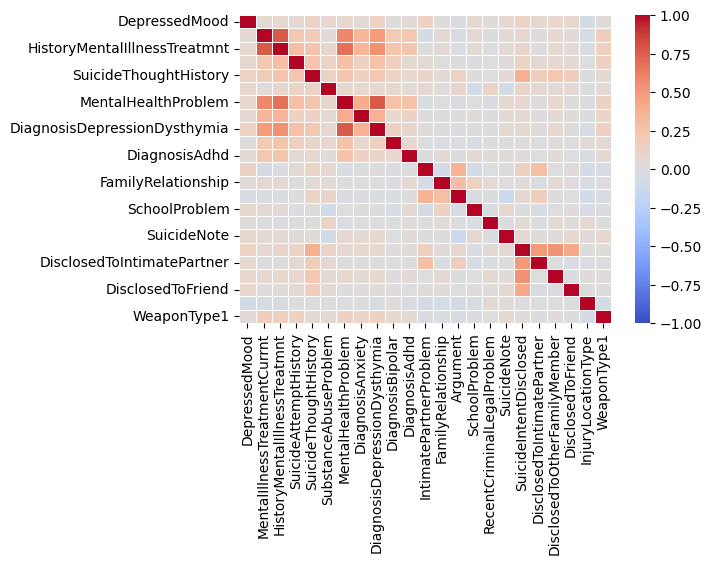

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(Y_train_df.corr(), cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.show()

## Single output model for single variable

In [ ]:
col = Y_train_df.columns[0]
# model = xgb.XGBClassifier()
model = xgb.XGBClassifier(tree_method='hist', device='cuda')
model.fit(X_train, Y_train_df[col])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train_df[col].values)

In [ ]:
cv_scores = cross_val_score(model, X_train, Y_train_df[col], cv=5, scoring='accuracy')

print(f'Scores de cross-validation: {cv_scores}')
print(f'Promedio de accuracy: {cv_scores.mean()}')
print(f'Desviación estándar: {cv_scores.std()}')

Scores de cross-validation: [0.3725  0.4025  0.3275  0.37375 0.32875]
Promedio de accuracy: 0.36100000000000004
Desviación estándar: 0.028911502901094583


## Multiple single output models

In [ ]:
models = {}
for idx, col in enumerate(Y_train_df.columns):
    model = xgb.XGBClassifier()
    model.fit(X_train, Y_train_df[col])
    models[col] = model
    print(idx)

0


## Multiple output model

In [ ]:
model = MultiOutputClassifier(XGBClassifier())
# model.fit(X_train, Y_train)

In [ ]:
# cv_scores = cross_val_score(model, X_train, Y_train_df, cv=5, scoring='accuracy')

# print(f'Scores de cross-validation: {cv_scores}')
# print(f'Promedio de accuracy: {cv_scores.mean()}')
# print(f'Desviación estándar: {cv_scores.std()}')

from sklearn.metrics import make_scorer



def multioutput_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)
multioutput_scorer = make_scorer(multioutput_accuracy)
cv_scores = cross_val_score(model, X_train, Y_train_df, cv=5, scoring=multioutput_scorer)

# Mostrar los resultados
print(f'Scores de cross-validation: {cv_scores}')
print(f'Promedio de accuracy: {cv_scores.mean()}')
print(f'Desviación estándar: {cv_scores.std()}')


KeyboardInterrupt: 

# Testing

In [ ]:
Y_test_df = target_test
Y_test = target_test.values

In [ ]:
X_test = vectorizer.transform(features_test["Narrative"])
X_test_df = pd.DataFrame(X_test.toarray(), columns=words)

X_test_df.head()

,00,00 30,00 57,00 am,00 and,00 buck,00 buckshot,00 by,00 cell,00 clock,...,â½ empty,â½ hour,â½ hrs,â½ inch,â½ month,â½ week,â½ wide,â½ yellow,â¾,â¾ of
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Single output model for single variable

In [ ]:
col = Y_train_df.columns[0]
Y_pred = model.predict(X_test)
print(f"Accuracy for {col}: ", accuracy_score(Y_test_df[col], Y_pred))

Accuracy for DepressedMood:  1.0


## Single output

In [ ]:
for col in Y_test_df.columns:
    Y_pred = models[col].predict(X_test)
    print(f"Accuracy for {col}: ", accuracy_score(Y_test_df[col], Y_pred))

Accuracy for DepressedMood:  1.0


## Multiple output

In [ ]:
Y_pred = model.predict(X_test)
np.power(Y_pred-Y_test, 2).mean()

0.0

In [ ]:
setA = set(features_train.index)
setB = set(features_test.index)
len(setA), len(setB), len(setA - setB), len(setB - setA)

(4000, 25, 3975, 0)

In [ ]:
setA = set(features_train["Narrative"].values)
setB = set(features_test["Narrative"].values)
len(setA), len(setB), len(setA - setB), len(setB - setA)

(3999, 25, 3974, 0)